In [1]:
%load_ext blackcellmagic
%load_ext notexbook

%texify

# Model Inversion Attack - Model Training

In this notebook we will be performing the training of **two** (out of three) of the ML models considered in the paper:

> **Model Inversion Attacks that Exploit Confidence Information and Basic Countermeasures**, by _Fredrikson, et. al_, 2015 
[DOI](https://dl.acm.org/doi/pdf/10.1145/2810103.2813677).

The two models are `SoftmaxRegression` and `MLP`.

⚠️ **NOTE**: Please feel free to skip this notebook completely (if you don't want to **re-train** the models on your own) and jump directly to the next [MIA Reconstruction](./MIA%20Reconstruction.ipynb) notebook.

In [2]:
import torch as th
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

In [4]:
from dataset import ORLFaces
from torchvision.transforms import ToTensor, Grayscale, Compose
from torch.utils.data import DataLoader

In [5]:
# Reproducibility Settings

SEED = 123456

np.random.seed(SEED)
th.manual_seed(SEED)
if th.cuda.is_available():
    th.coda.manual_seed_all(SEED)
    th.backends.cudnn.deterministic = True

### The `ORLFaces` Dataset

The original paper considers the **AT&T Face Database** faces dataset (which I have encapsualted and made available as a PyTorch `Dataset`): `ORLFaces`

In [6]:
from pathlib import Path
import os

DATA_FOLDER = Path(os.path.join(os.path.abspath(os.path.curdir), "..", "..")) / "data"

In [7]:
imgs_trasform = Compose([Grayscale(num_output_channels=1), ToTensor()])

orl_faces_train = ORLFaces(
    root=DATA_FOLDER, download=True, split="train", transform=imgs_trasform
)
orl_faces_test = ORLFaces(
    root=DATA_FOLDER, download=True, split="test", transform=imgs_trasform
)

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    orl_faces_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
test_loader = DataLoader(
    orl_faces_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

#### A few notes about the dataset 

The `ORLFaces` dataset contains `400` image files corresponding to `40` different subjects (`10` photo each).


Images are `112x92` pixels, with `256` grey levels per pixel, and (originally) stored in `PGM` format.
The photos of the subjects have been taken at different times, are varying the lightning, the facial expressions
    (e.g. open/closed eyes, smiling/serious face), and the facial details.

**Train/Test** partitions have been generated similarly to what has been done in the original paper, that is: 

(for each subject):

- Randomly pick $7$ (out of $10$) images of the subject and add them to the **training set**
- Add remaining $3$ images to the **test set**

#### Visualise a few Samples in the Dataset

Before we start with the training, let's visualise a few random samples extracted from the dataset

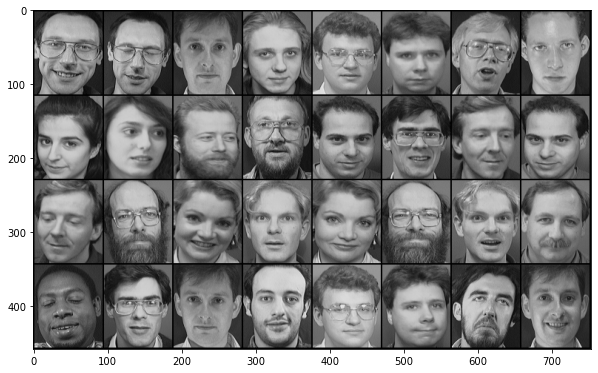

26 26 23 11 5 22 1 0 9 7 25 13 8 19 2 8 2 36 34 17 34 36 17 24 21 19 23 15 5 22 10 23


In [9]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(" ".join(f"{labels[j]}" for j in range(BATCH_SIZE)))

ℹ️ **Note**: Do you see the **exact same faces** that are being displayed here? 

## Machine Learning Model Training

In the original Paper, authors refer to three separated models used as reference examples for the Model Inversion Attack. 

Here to keep things simple, we will only consider two of them: `SoftmaxRegression` and `MLP`

In [10]:
from models import SoftmaxRegression, MLP

In [11]:
from train import train

In [12]:
λ = 0.1  # optimiser learning rate, as used in the paper

#### Training `SoftmaxRegression`

Note: This should be super-fast even on a laptop (small model, small data)

In [13]:
softmax_reg = SoftmaxRegression()
softmax_sgd = th.optim.SGD(softmax_reg.parameters(), lr=λ)

In [14]:
softmax_reg

SoftmaxRegression(
  (regression): Linear(in_features=10304, out_features=40, bias=True)
)

In [15]:
train(
    model=softmax_reg,
    optimiser=softmax_sgd,
    loaders=(train_loader, test_loader),
    model_name="softmax_mia",
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

checkpoints/softmax_mia.pt
Best Validation ACC: 0.5166666666666667
checkpoints/softmax_mia.pt
Best Validation ACC: 0.925
checkpoints/softmax_mia.pt
Best Validation ACC: 0.9333333333333333
checkpoints/softmax_mia.pt
Best Validation ACC: 0.9416666666666667


### Training `MLP`

⚠️ **Note**:  This may be a bit slower to train on a laptop (it shouldn't be that much, though!) 

If you notice that it is the case, please also feel free to skip this and jump at the end of this notebook.

In [ ]:
mlp = MLP()
mlp_sgd = th.optim.SGD(mlp.parameters(), lr=λ)

In [ ]:
mlp

In [ ]:
train(
    model=mlp,
    optimiser=mlp_sgd,
    loaders=(train_loader, test_loader),
    model_name="mlp_mia",
)

### Congratulations

**Well done** 🎉

Now that we have our two reference **trained** model, we are ready to setup and launch the _model inversion_ attack to the model. 

$\rightarrow$ [MIA Reconstruction](./MIA%20Reconstruction.ipynb)